In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import logit
from scipy.optimize import minimize
from tqdm import tqdm

# append paths
sys.path.append('../../')

# local imports
from process.tables import *
from models.bayes import *
from models.predict import *
from process.config import *
from process.measurements import cutoff_measurements_df
from models.ornstein_uhlenbeck import (
    run_ou_with_prior,
    estimate_ou_parameters_with_prior
)


,patient_id,target,pred_healthy,pred_unhealthy,actual_target_health,health_pred_healthy,health_pred_unhealthy,input_values,input_times,input_normal,forecast_time,num_input_points
0,115972598,14.7,9.372252,9.182574,1.0,-2.686785,-2.930303,[ 9.3 11.8 12.5 6.7 9.2 8.5 10.5 10.9 11.8 ...,"[Timestamp('2008-07-13 12:50:00'), Timestamp('...",[False False True False False False False Fal...,2022-07-21 09:20:00,10
1,115971629,9.6,10.959305,10.785386,0.0,-3.894123,-4.143535,[8.3 9.9],"[Timestamp('2020-10-17 06:05:00'), Timestamp('...",[False False],2021-04-06 11:01:00,2
2,115970264,14.8,11.119322,10.946435,1.0,-3.753288,-4.002927,[10.1 15.1],"[Timestamp('2003-08-03 11:00:00'), Timestamp('...",[False True],2021-07-03 10:31:00,2
3,115967262,8.8,11.016107,10.841279,0.0,-3.933417,-4.182546,[7.6 6.5],"[Timestamp('2016-12-12 08:23:00'), Timestamp('...",[False False],2017-04-30 08:35:00,2
4,115970860,9.4,10.914039,10.740848,0.0,-3.857907,-4.107600,[11.6 11.5],"[Timestamp('2017-04-06 20:34:00'), Timestamp('...",[False False],2018-01-18 06:35:00,2
5,115969276,8.5,10.986619,10.812270,0.0,-3.913377,-4.162669,[7.8 8.1],"[Timestamp('2020-04-07 19:50:00'), Timestamp('...",[False False],2020-04-15 06:49:00,2
6,115973202,8.6,10.476260,10.300925,0.0,-3.554951,-3.806395,[10. 9.4 10.8],"[Timestamp('2008-06-08 05:20:00'), Timestamp('...",[False False False],2011-01-12 11:50:00,3
7,115967448,11.7,11.105170,10.925413,0.0,-3.083566,-3.332675,[12.7 12.2 7.9 7.4],"[Timestamp('2015-06-30 04:09:00'), Timestamp('...",[ True True False False],2016-11-23 08:17:00,4
8,115970776,10.1,10.460006,10.284901,0.0,-3.538207,-3.789735,[12.9 9.5 10.5],"[Timestamp('2012-03-16 10:42:00'), Timestamp('...",[False False False],2013-09-18 05:05:00,3
9,115972398,8.9,10.949462,10.775698,0.0,-3.882341,-4.131783,[10.6 8.5],"[Timestamp('2008-09-29 08:30:00'), Timestamp('...",[False False],2011-04-14 06:00:00,2


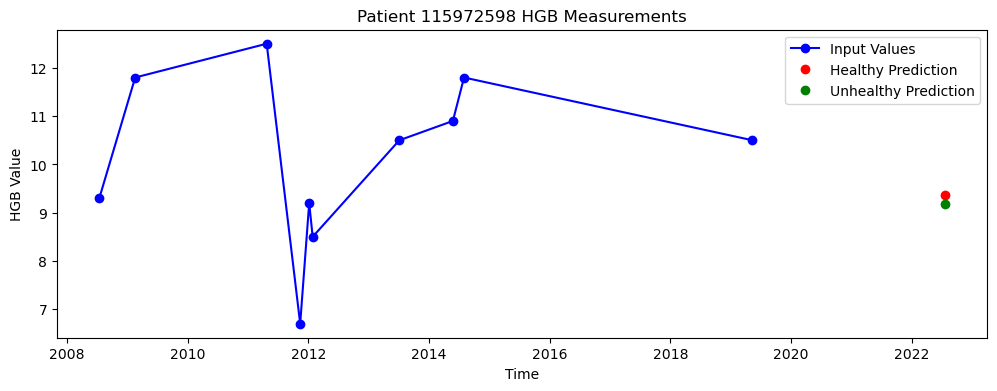

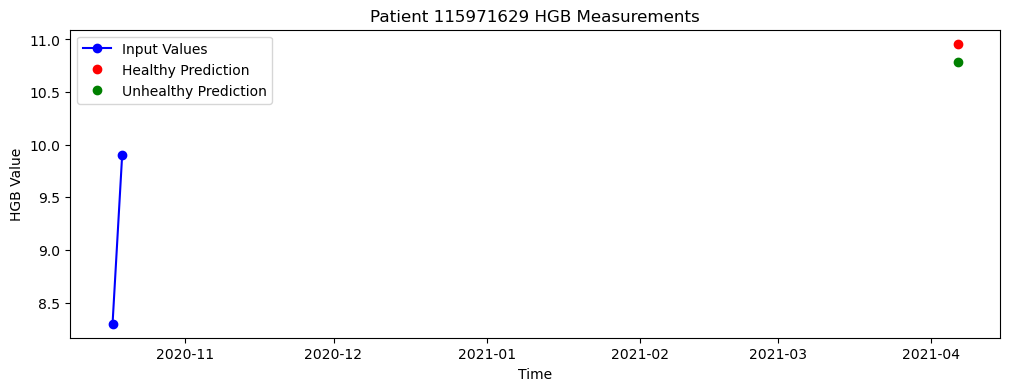

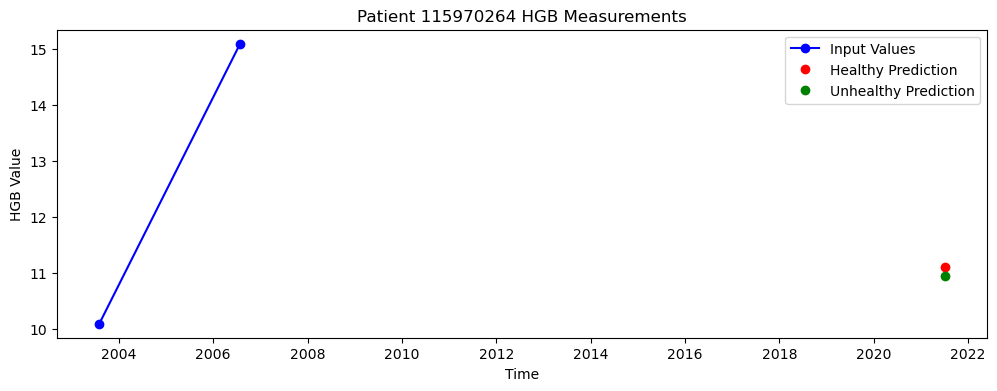

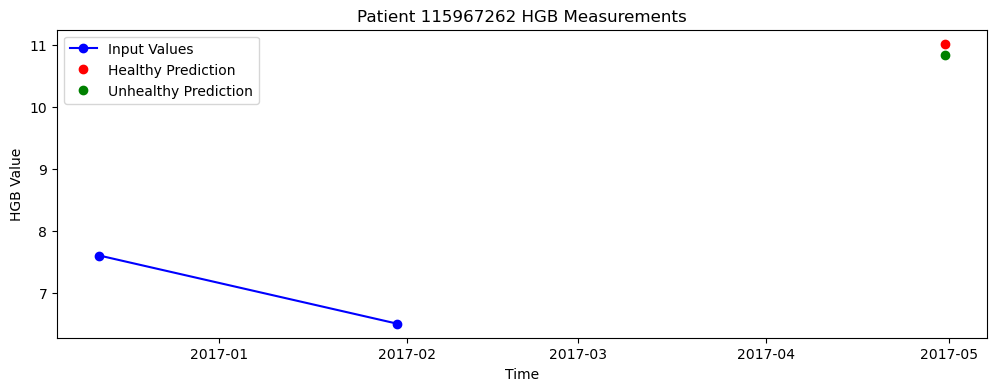

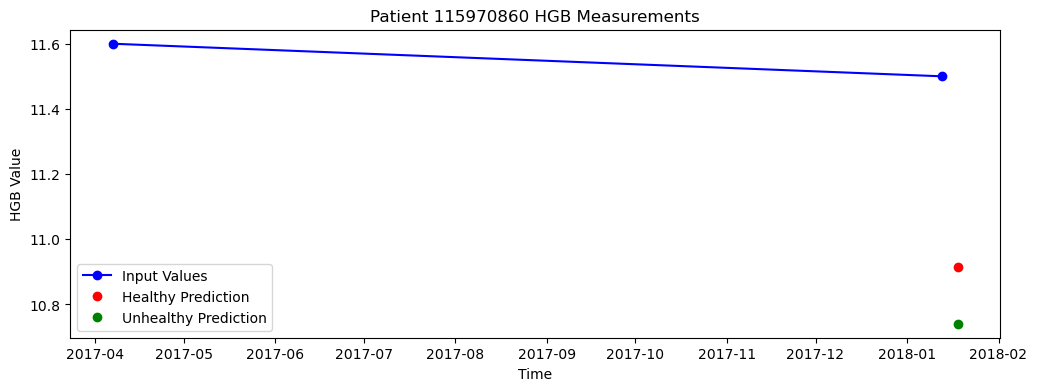

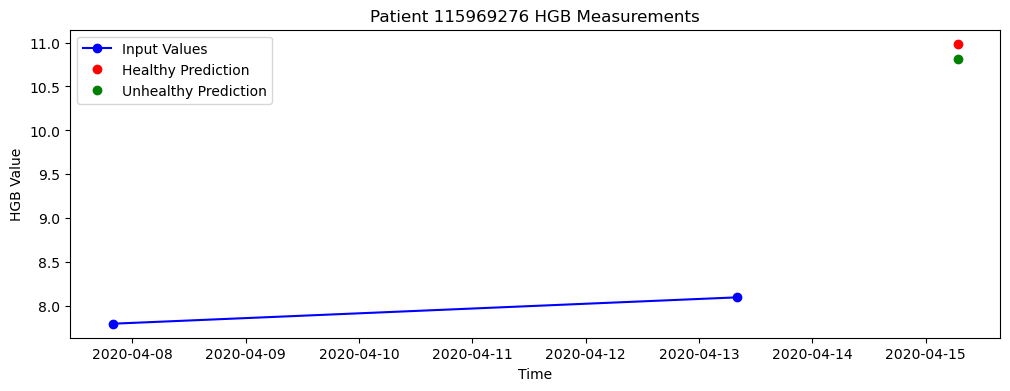

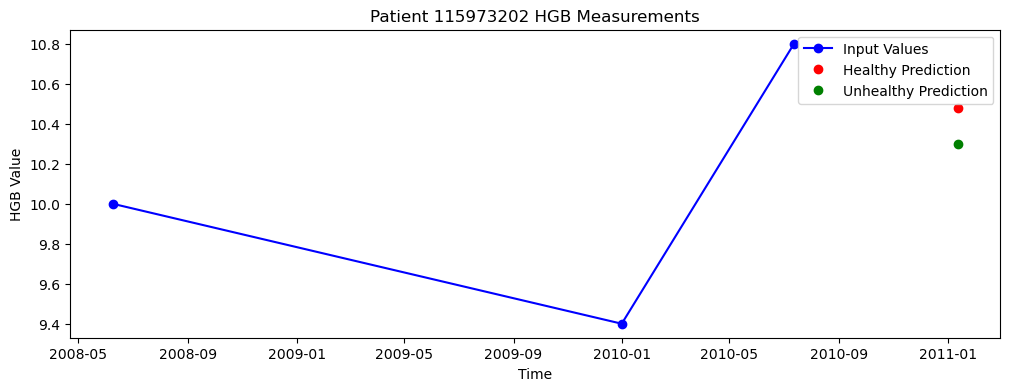

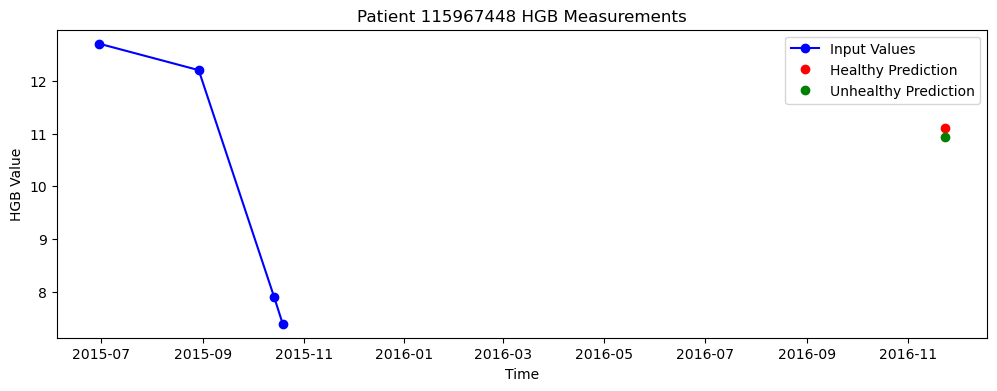

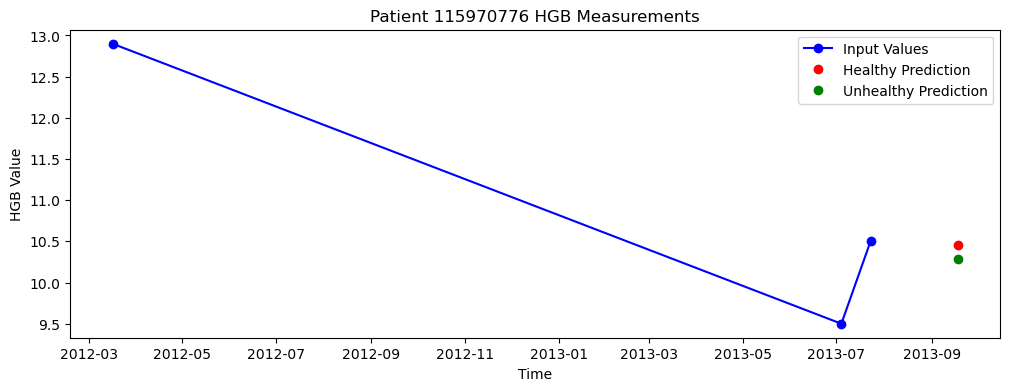

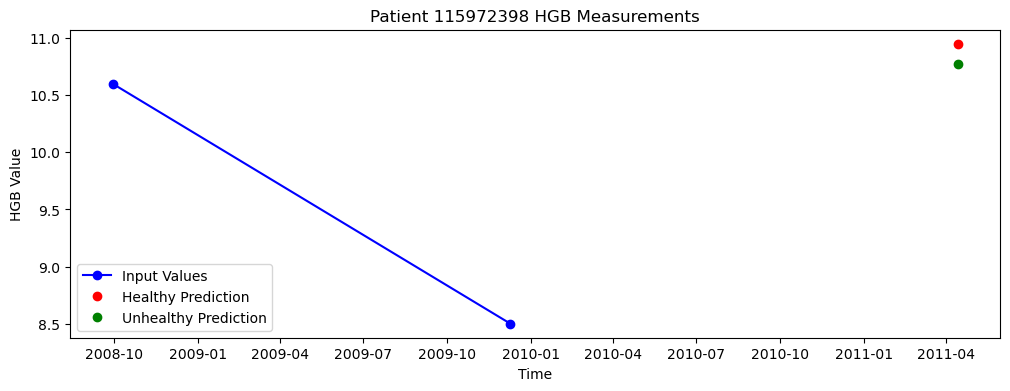

<Figure size 1200x400 with 0 Axes>

In [160]:
# load the results
results = pd.read_csv('../../results/norma/model_summary_health_huber.csv')
predictions = pd.read_csv('../../results/norma/test_predictions_health_huber.csv')
health_predictions = pd.read_csv('../../results/norma/test_predictions_health_huber.csv')
display(health_predictions)


# sample patients and get their input data and predictions
plt.figure(figsize=(12, 4))  # Make plots wider

count = 0
for patient_id in health_predictions['patient_id'].unique():
    sample_predictions = health_predictions[health_predictions['patient_id'] == patient_id]
    
    # Convert string representations of lists back to numpy arrays
    input_values = np.fromstring(sample_predictions['input_values'].iloc[0].strip('[]'), sep=' ')

    # Parse the timestamp strings more carefully
    input_times_str = sample_predictions['input_times'].iloc[0].strip('[]').replace("'", "").split(',')
    input_times_str = [s.strip() for s in input_times_str]  # Remove whitespace
    input_times = [pd.Timestamp(ts.replace('Timestamp(', '').replace(')', '')) for ts in input_times_str]    
    forecast_time = pd.Timestamp(sample_predictions['forecast_time'].iloc[0])
    
    # Plot input values
    plt.plot(input_times, input_values, 'bo-', label='Input Values')
    #plt.plot(forecast_time, sample_predictions['prediction'], 'ro', label='Predicted Value')
    #plt.plot(forecast_time, sample_predictions['target'], 'go', label='True Value')
    plt.plot(forecast_time, sample_predictions['pred_healthy'], 'ro', label='Healthy Prediction')

    plt.plot(forecast_time, sample_predictions['pred_unhealthy'], 'go', label='Unhealthy Prediction')

    plt.title(f'Patient {patient_id} HGB Measurements')
    plt.xlabel('Time')
    plt.ylabel('HGB Value')
    plt.legend()
    plt.show()
    
    # Create new figure for next plot
    plt.figure(figsize=(12, 4))
    
    count += 1
    if count >= 10:  # Stop after 5 patients
        break

,patient_id,target,pred_healthy,pred_unhealthy,actual_target_health,true_prediction,health_pred_healthy,health_pred_unhealthy,input_values,input_times,input_normal,forecast_time,num_input_points,std_healthy,std_unhealthy
0,115969177,10.0,14.641416,10.999923,0.0,10.999923,0.275125,0.275125,[ 9.7 12.4 12.5 11.7 12.9 8. 12.2 10.9 9.7 ...,"[Timestamp('2015-02-13 04:52:00'), Timestamp('...",[False False False False False False False Fal...,2022-10-17 06:41:00,25,1.260538,1.817558
1,115970001,15.2,14.495914,10.854423,1.0,14.495914,0.275125,0.275125,[15.2 15.7 13.5 13.3 13.6 13.1 14.9 11.3 12.6 ...,"[Timestamp('2014-01-14 09:57:00'), Timestamp('...",[ True True False False False False True Fal...,2020-10-04 08:09:00,28,1.055149,1.521410
2,115968849,9.9,12.930942,9.289449,0.0,9.289449,0.275125,0.275125,[9.6 9.6],"[Timestamp('2016-12-10 07:08:00'), Timestamp('...",[False False],2016-12-11 06:06:00,2,1.006740,1.451609
3,115970404,10.0,14.633348,10.991856,0.0,10.991856,0.275125,0.275125,[ 8.3 11.2 9.3 8.4 8.1 7.7 9.5 12.9 10.3],"[Timestamp('2015-10-06 10:10:00'), Timestamp('...",[False False False False False False False Fal...,2016-07-14 09:30:00,9,1.559916,2.249227
4,115971509,12.3,13.689428,10.047935,1.0,13.689428,0.275125,0.275125,[ 8.2 7.9 7.5 8.4 8.1 10.5 10.9 11.3 11. ...,"[Timestamp('1999-05-04 18:15:00'), Timestamp('...",[False False False False False False False Fal...,2018-12-25 15:01:00,39,1.233028,1.777891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,115969074,10.0,14.517849,10.876356,0.0,10.876356,0.275125,0.275125,[ 8.3 8.2 11.9],"[Timestamp('2017-07-07 06:12:00'), Timestamp('...",[False False False],2017-09-08 05:09:00,3,1.414983,2.040250
329,115971286,11.4,14.140631,10.499138,0.0,10.499138,0.275125,0.275125,[16.6 14.6 14.9 14.8 13.6 12.6 11.5 14.2 10.7 ...,"[Timestamp('2017-12-13 11:06:00'), Timestamp('...",[ True True True True False False False Tr...,2022-01-23 23:39:00,40,2.090408,3.014140
330,115972721,12.1,12.957478,9.315986,1.0,12.957478,0.275125,0.275125,[ 9.8 9.1 11.2 11.2 8.9 11.1 12.2 13.2],"[Timestamp('2009-11-22 07:02:00'), Timestamp('...",[False False False False False False True True],2022-09-21 05:39:00,8,1.099192,1.584914
331,115972523,8.7,12.795391,9.153898,0.0,9.153898,0.275125,0.275125,[13.4 12. 10.2 10.1 9.2 8.3 8.8 9.4 9.8 ...,"[Timestamp('2017-07-02 21:26:00'), Timestamp('...",[ True False False False False False False Fal...,2018-07-13 05:27:00,11,1.291033,1.861528


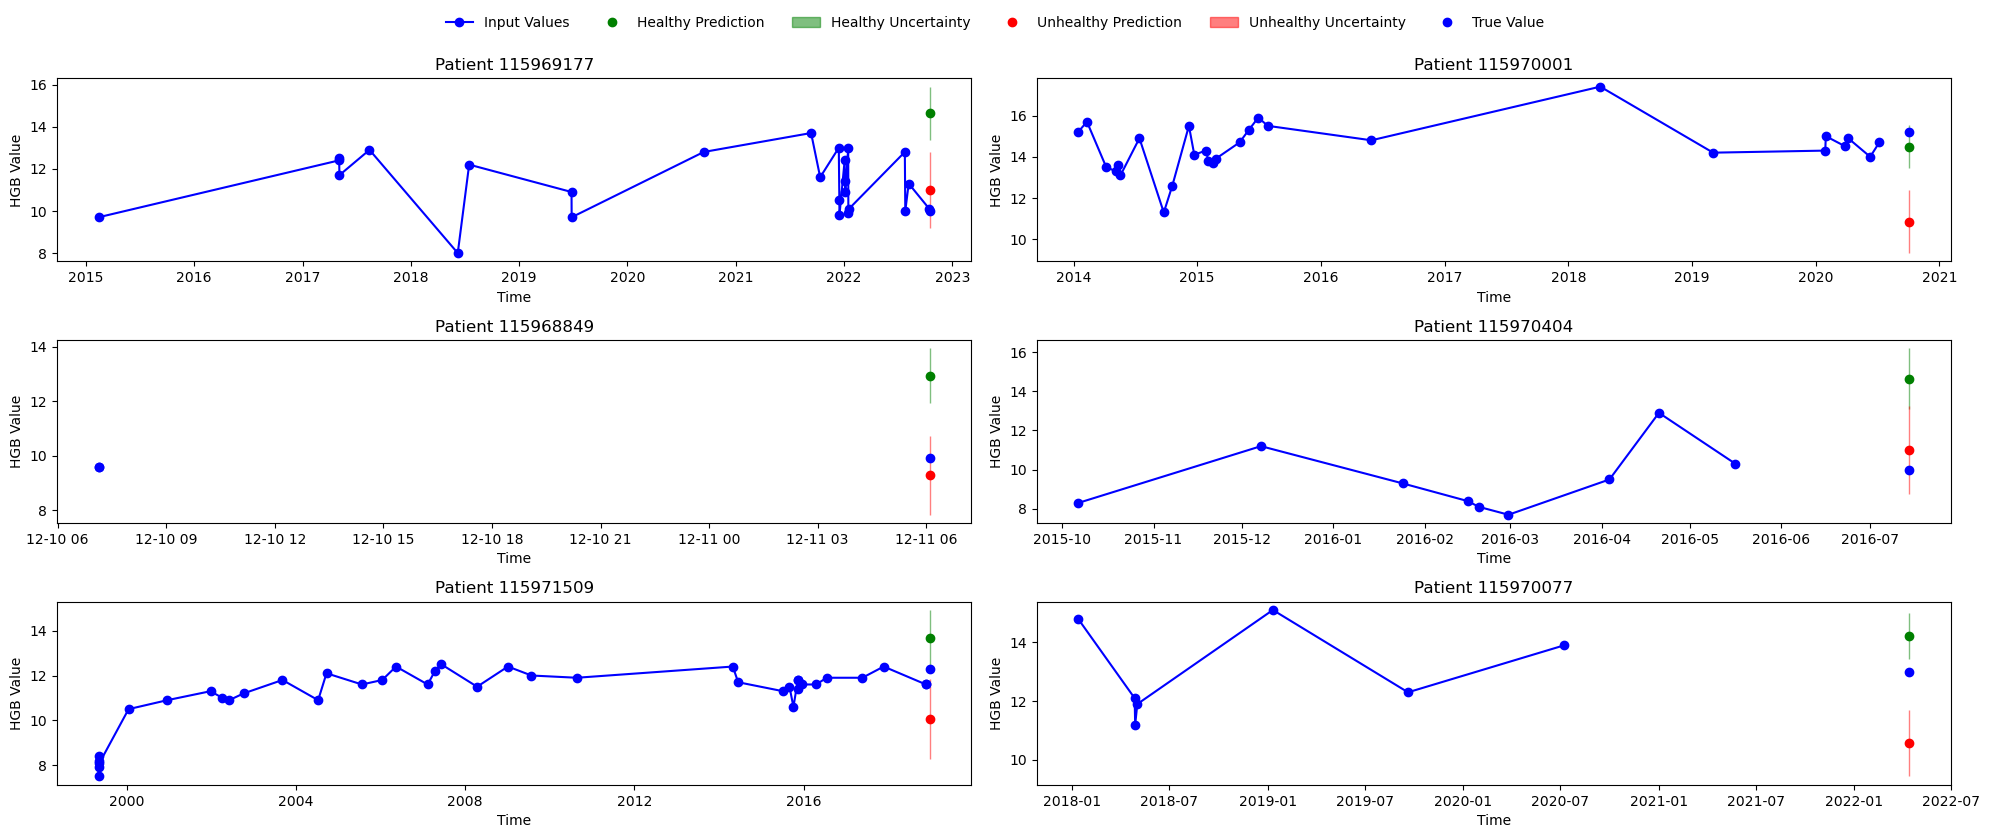

In [151]:
# load the results
results = pd.read_csv('../../results/norma/model_summary_health_nll_sample_0.3.csv')
predictions = pd.read_csv('../../results/norma/test_predictions_health_nll_sample_0.3.csv')
health_predictions = pd.read_csv('../../results/norma/test_predictions_health_nll_sample_0.3.csv')
display(health_predictions)

# Create one figure for all plots
fig, axes = plt.subplots(3, 2, figsize=(20, 8))
axes = axes.ravel()

count = 0
for patient_id in health_predictions['patient_id'].unique():
    if count >= 6:  # Stop after 10 patients
        break
        
    sample_predictions = health_predictions[health_predictions['patient_id'] == patient_id]
    input_values = np.fromstring(sample_predictions['input_values'].iloc[0].strip('[]'), sep=' ')

    # Parse the timestamp strings more carefully
    input_times_str = sample_predictions['input_times'].iloc[0].strip('[]').replace("'", "").split(',')
    input_times_str = [s.strip() for s in input_times_str]  # Remove whitespace
    input_times = [pd.Timestamp(ts.replace('Timestamp(', '').replace(')', '')) for ts in input_times_str]    
    forecast_time = pd.Timestamp(sample_predictions['forecast_time'].iloc[0])
    
    # Plot input values
    axes[count].plot(input_times, input_values, 'bo-', label='Input Values')
    axes[count].plot(forecast_time, sample_predictions['pred_healthy'], 'go', label='Healthy Prediction')
    axes[count].fill_between([forecast_time], 
                           sample_predictions['pred_healthy'] - sample_predictions['std_healthy'],
                           sample_predictions['pred_healthy'] + sample_predictions['std_healthy'], 
                           alpha=0.5, color='green', label='Healthy Uncertainty')

    axes[count].plot(forecast_time, sample_predictions['pred_unhealthy'], 'ro', label='Unhealthy Prediction')
    axes[count].fill_between([forecast_time],
                           sample_predictions['pred_unhealthy'] - sample_predictions['std_unhealthy'],
                           sample_predictions['pred_unhealthy'] + sample_predictions['std_unhealthy'],
                           alpha=0.5, color='red', label='Unhealthy Uncertainty')

    axes[count].plot(forecast_time, sample_predictions['target'], 'bo', label='True Value')
    
    axes[count].set_title(f'Patient {patient_id}')
    axes[count].set_xlabel('Time')
    axes[count].set_ylabel('HGB Value')
    
    if count == 0:  # Add legend above the entire plot
        fig.legend(bbox_to_anchor=(0.5, 1.05), loc='upper center', ncol=6, frameon=False)
    count += 1

plt.tight_layout()
plt.show()

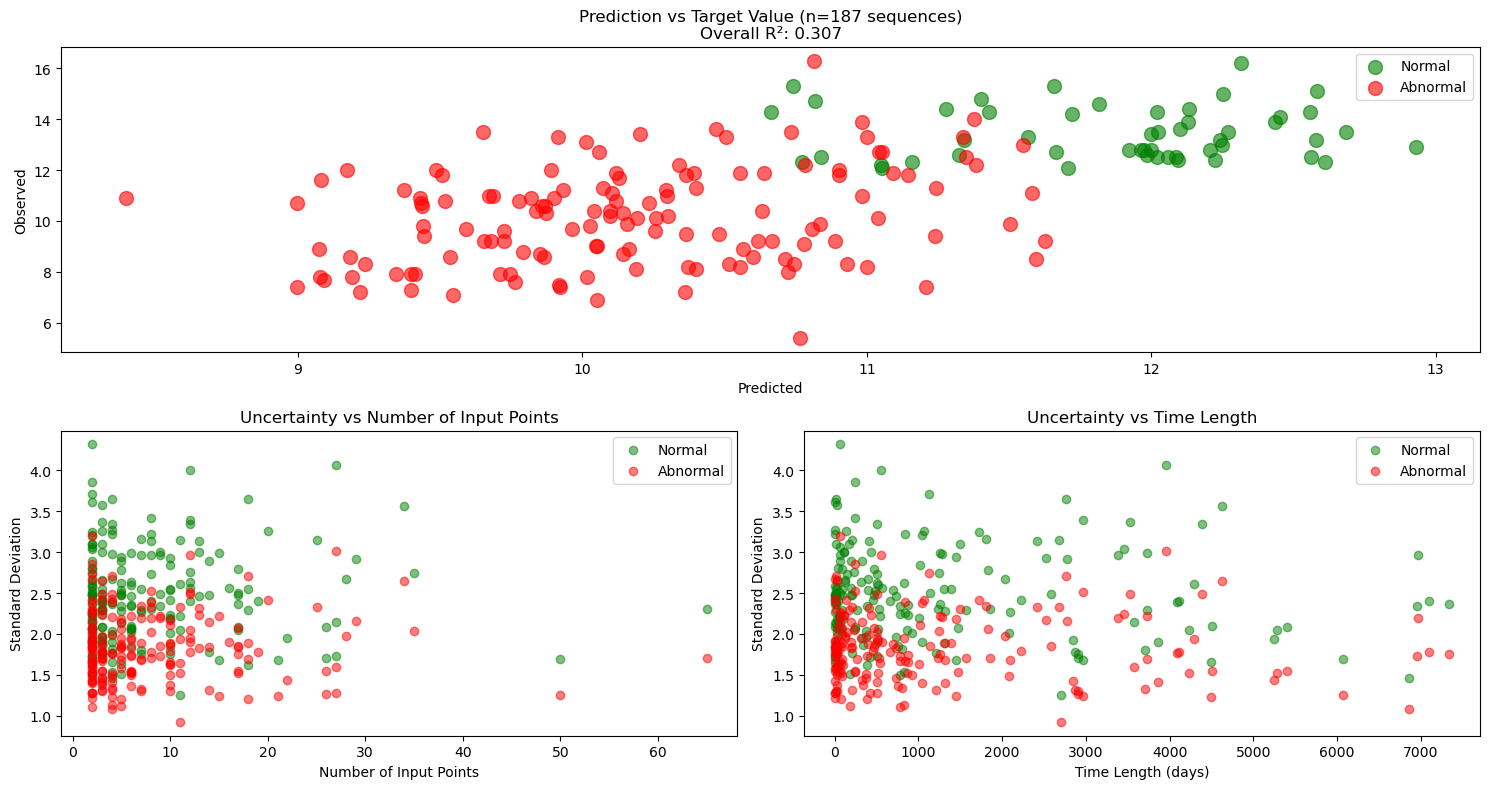

In [148]:
# plot the target value vs the true prediction value for the actual health status

# load the predictions
predictions = pd.read_csv('../../results/norma/test_predictions_health_nll_sample_0.1.csv')
from sklearn.metrics import r2_score

# Calculate time length and input std for each sequence
time_lengths = []
input_stds = []
for idx, row in predictions.iterrows():
    # Get times
    input_times_str = row['input_times'].strip('[]').replace("'", "").split(',')
    input_times_str = [s.strip() for s in input_times_str]
    input_times = [pd.Timestamp(ts.replace('Timestamp(', '').replace(')', '')) for ts in input_times_str]
    time_length = (input_times[-1] - input_times[0]).total_seconds() / (60 * 60 * 24) # Convert to days
    time_lengths.append(time_length)
    
    # Get std of input values
    input_values = np.fromstring(row['input_values'].strip('[]'), sep=' ')
    input_stds.append(np.std(input_values) if len(input_values) > 1 else 0)

predictions['time_length'] = time_lengths
predictions['input_std'] = input_stds
predictions['points_per_day'] = predictions['num_input_points'] / predictions['time_length']

# Fit regression models for uncertainty analysis
from sklearn.linear_model import LinearRegression

# For normal predictions
X_normal = np.column_stack([
    predictions['num_input_points'],
    predictions['time_length'],
    predictions['input_std']
])
y_normal = predictions['std_healthy']
model_normal = LinearRegression().fit(X_normal, y_normal)

# For abnormal predictions  
X_abnormal = np.column_stack([
    predictions['num_input_points'],
    predictions['time_length'],
    predictions['input_std']
])
y_abnormal = predictions['std_unhealthy']
model_abnormal = LinearRegression().fit(X_abnormal, y_abnormal)

# Create figure with 2 rows
fig = plt.figure(figsize=(15, 8))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

# Top plot - predictions vs actual
ax0 = fig.add_subplot(gs[0, :])

# Create separate scatter plots for normal and abnormal points
normal_mask = predictions['actual_target_health'] == 1
abnormal_mask = predictions['actual_target_health'] == 0

ax0.scatter(predictions[normal_mask]['true_prediction'],
           predictions[normal_mask]['target'],
           c='green', label='Normal', alpha=0.6, s=100)

ax0.scatter(predictions[abnormal_mask]['true_prediction'],
           predictions[abnormal_mask]['target'],
           c='red', label='Abnormal', alpha=0.6, s=100)

# Calculate R² for healthy and unhealthy separately
r2_healthy = r2_score(predictions[normal_mask]['target'], predictions[normal_mask]['true_prediction'])
healthy_df = predictions.query('actual_target_health == 1')
unhealthy_df = predictions.query('actual_target_health == 0')
#r2_healthy = r2_score(healthy_df['target'], healthy_df['true_prediction'])
#r2_unhealthy = r2_score(unhealthy_df['target'], unhealthy_df['true_prediction'])
r2_overall = r2_score(predictions['target'], predictions['true_prediction'])

ax0.set_xlabel('Predicted')
ax0.set_ylabel('Observed')
ax0.set_title(f'Prediction vs Target Value (n={len(predictions)} sequences)\nOverall R²: {r2_overall:.3f}') #, Healthy R²: {r2_healthy:.3f}, Unhealthy R²: {r2_unhealthy:.3f}')
ax0.legend()

# Bottom left - Number of points vs std
ax1 = fig.add_subplot(gs[1, 0])
ax1.scatter(predictions['num_input_points'], predictions['std_healthy'], alpha=0.5, label='Normal', c='green')
ax1.scatter(predictions['num_input_points'], predictions['std_unhealthy'], alpha=0.5, label='Abnormal', c='red')
ax1.set_xlabel('Number of Input Points')
ax1.set_ylabel('Standard Deviation')
ax1.legend()
ax1.set_title('Uncertainty vs Number of Input Points')

# Bottom right - Time length vs std
ax2 = fig.add_subplot(gs[1, 1])
ax2.scatter(predictions['time_length'], predictions['std_healthy'], alpha=0.5, label='Normal', c='green')
ax2.scatter(predictions['time_length'], predictions['std_unhealthy'], alpha=0.5, label='Abnormal', c='red')
ax2.set_xlabel('Time Length (days)')
ax2.set_ylabel('Standard Deviation')
ax2.legend()
ax2.set_title('Uncertainty vs Time Length')

plt.tight_layout()
plt.show()


In [ ]:
pd.read_csv('../../results/norma/test_predictions_health_nll_sample_0.1.csv')

In [74]:
pd.read_csv('../../results/norma/model_summary_health_nll_sample_0.1.csv')

,loss_type,mse_healthy,mae_healthy,mse_unhealthy,mae_unhealthy,mse_overall,mae_overall,auc_healthy,auc_unhealthy,num_test_samples,model_parameters,avg_std_healthy,avg_std_unhealthy
0,nll,10.7983,2.700831,5.571273,1.991144,2.525551,1.298476,0.535401,0.535401,187,551035,1.594158,1.62855
